# Creation of segments 

In [ ]:
# import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "caching_allocator"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# torch.cuda.synchronize()

In [2]:
print("CUDA is available:", torch.cuda.is_available())

CUDA is available: True


In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

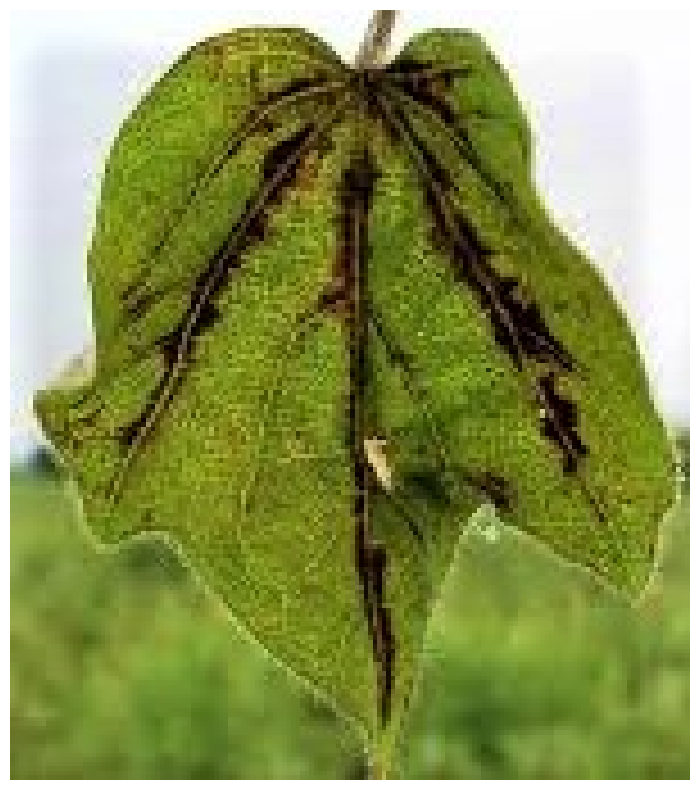

In [61]:
image = cv2.imread("G:\\NAVANEETH\\#Cotton_Leaf_Disease_Detection\\Dataset2\\Cotton-Disease-Training\\trainning\\Cotton leaves - Training\\800 Images\\Bacterial blight\\11.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

In [6]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [8]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [62]:
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

10
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


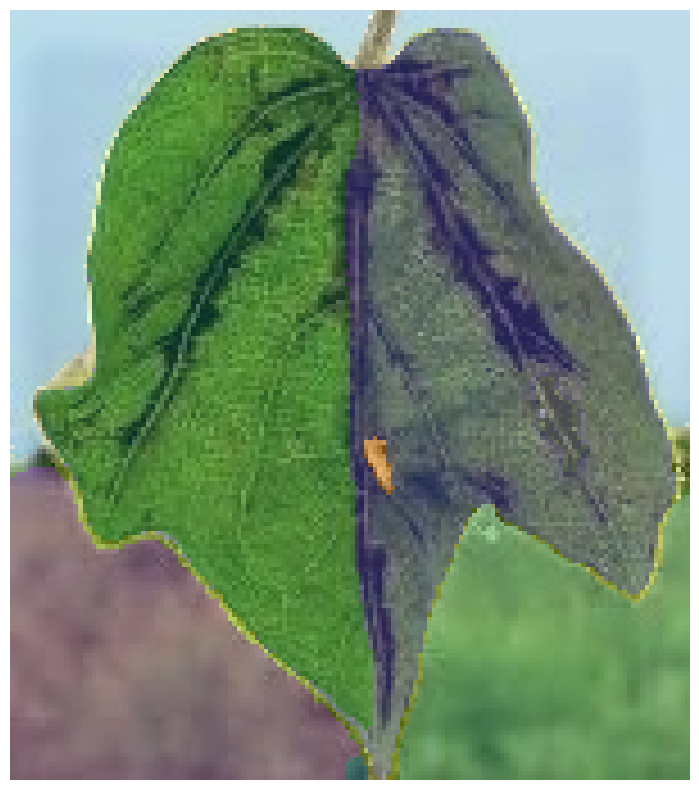

In [63]:
#Print the image with segmented parts
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

# Print all segments

In [66]:
# Load the original image
original_image = cv2.imread("G:\\NAVANEETH\\#Cotton_Leaf_Disease_Detection\\Dataset2\\Cotton-Disease-Training\\trainning\\Cotton leaves - Training\\800 Images\\Bacterial blight\\11.jpg")
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

In [67]:
# Iterate through masks and apply them to the original image
segmented_images = []
for mask in masks:
    segmentation_mask = mask['segmentation']
    # Create a binary mask with 1s where the segment is present
    binary_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    binary_mask[segmentation_mask] = 255

    # Apply the mask to the original image using bitwise AND operation
    segmented_image = cv2.bitwise_and(original_image_rgb, original_image_rgb, mask=binary_mask)
    segmented_images.append(segmented_image)

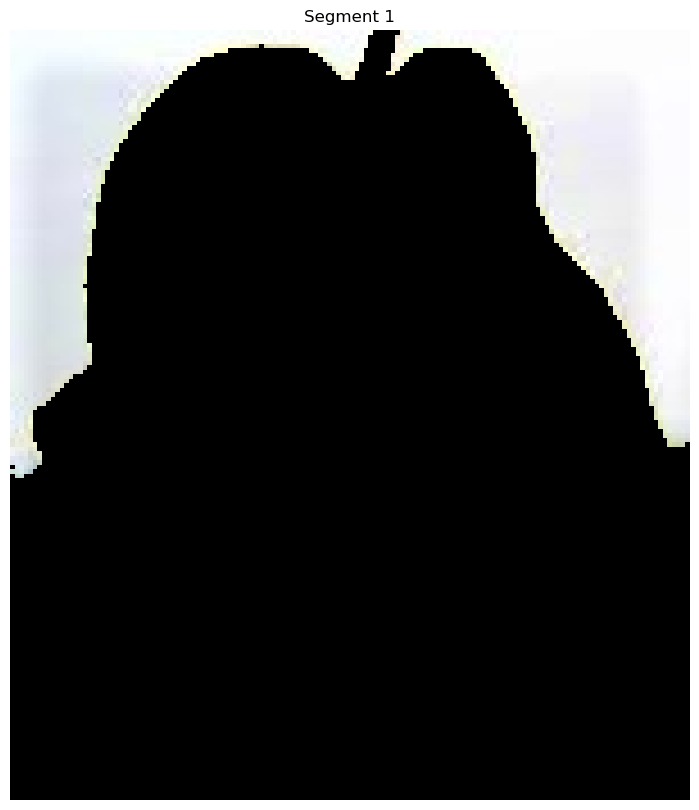

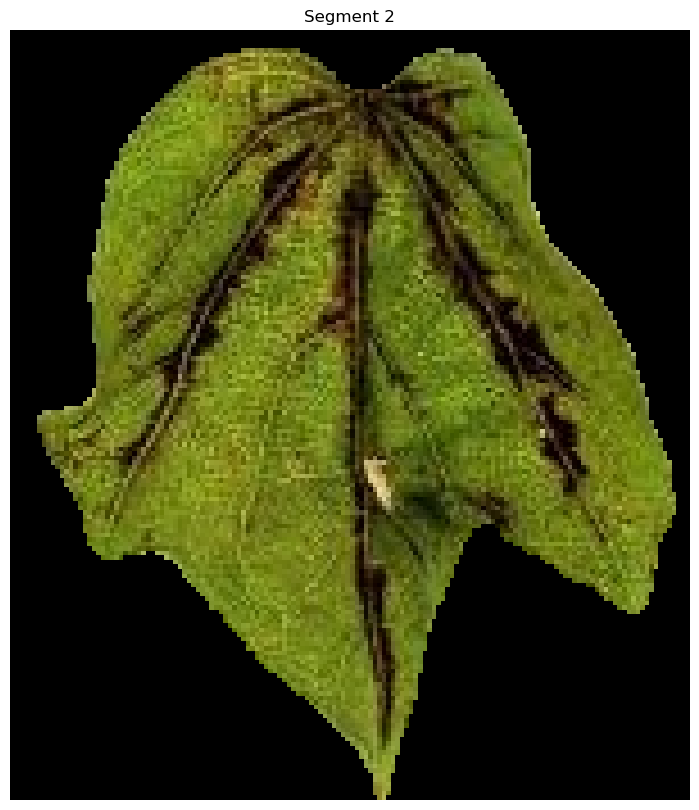

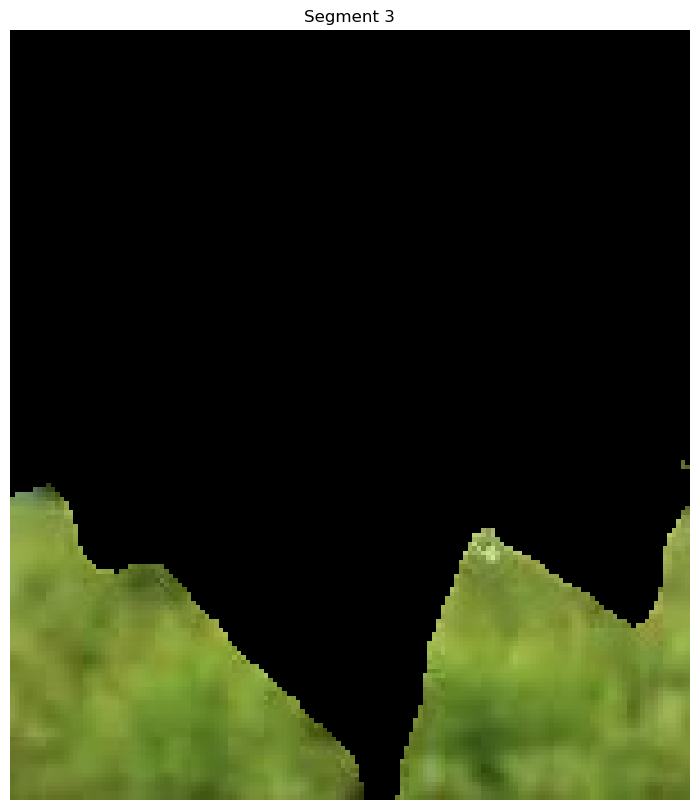

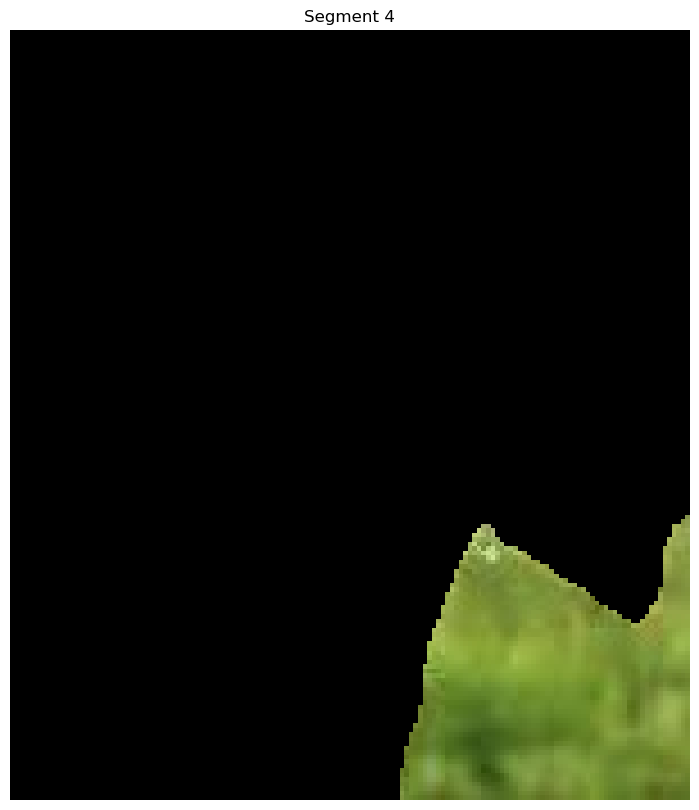

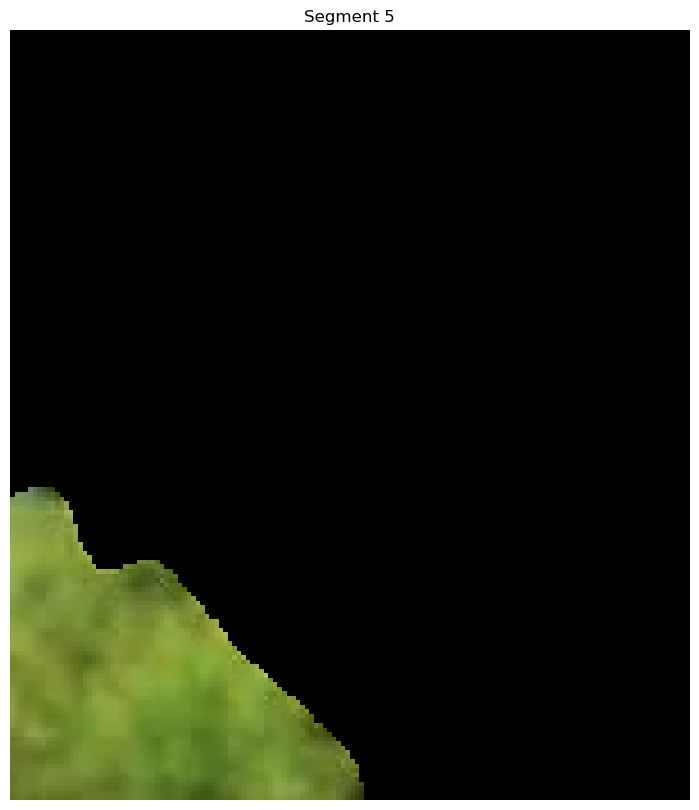

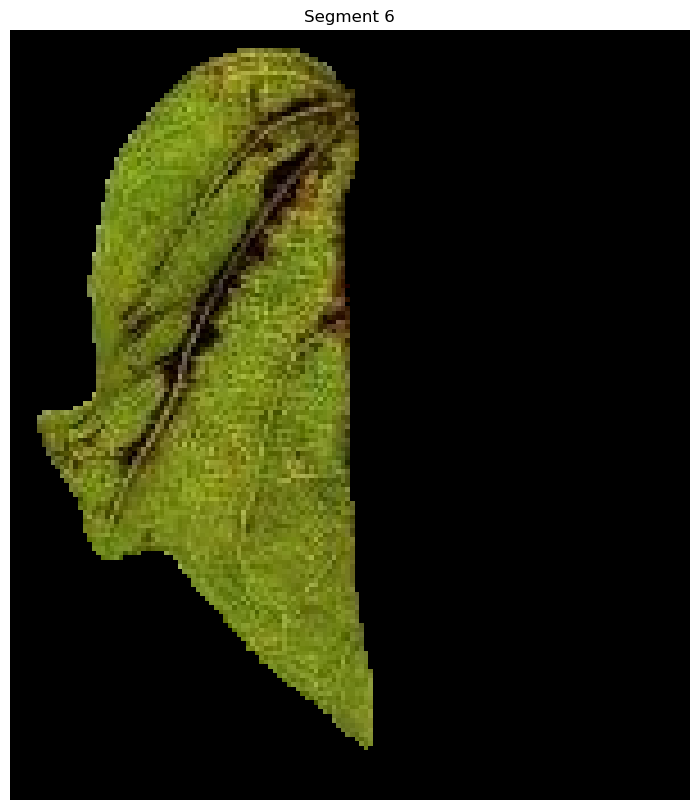

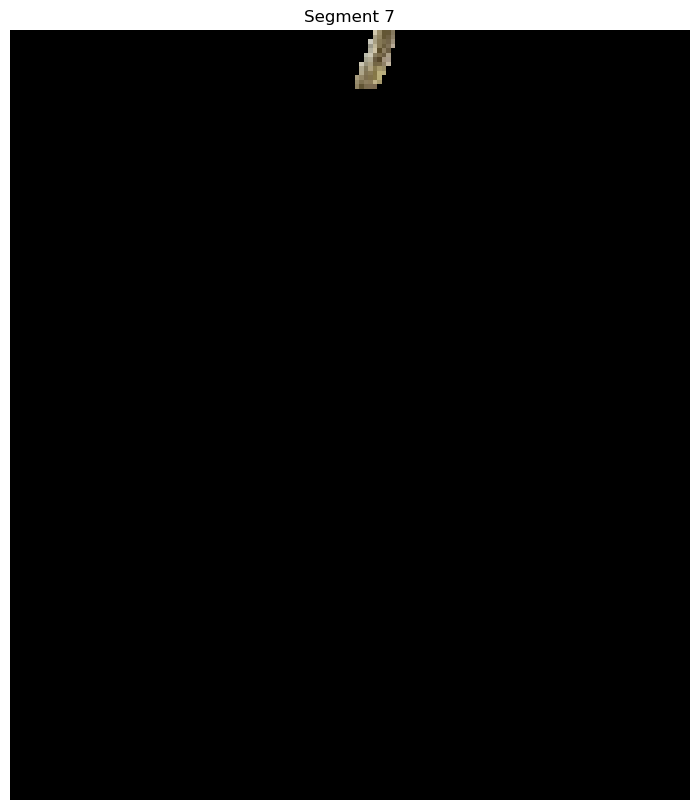

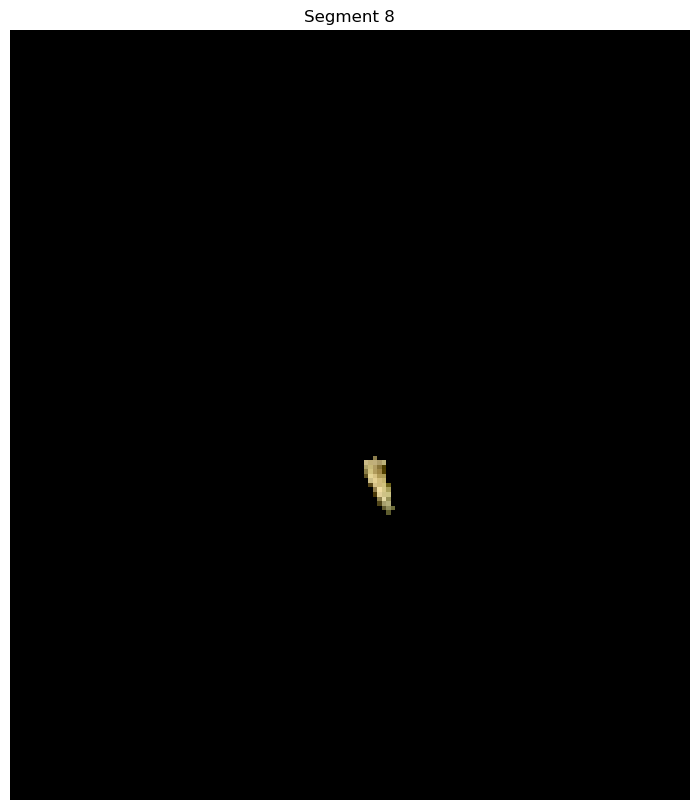

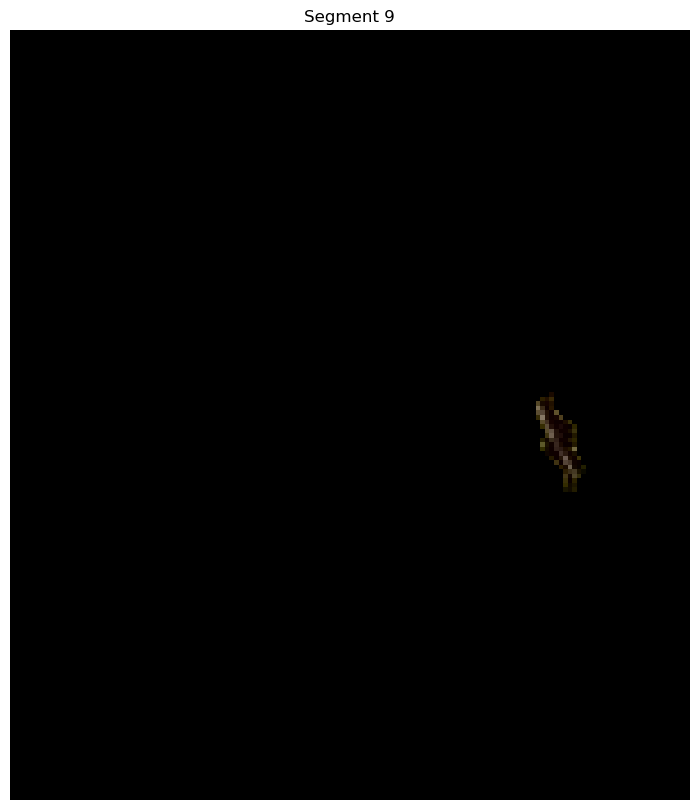

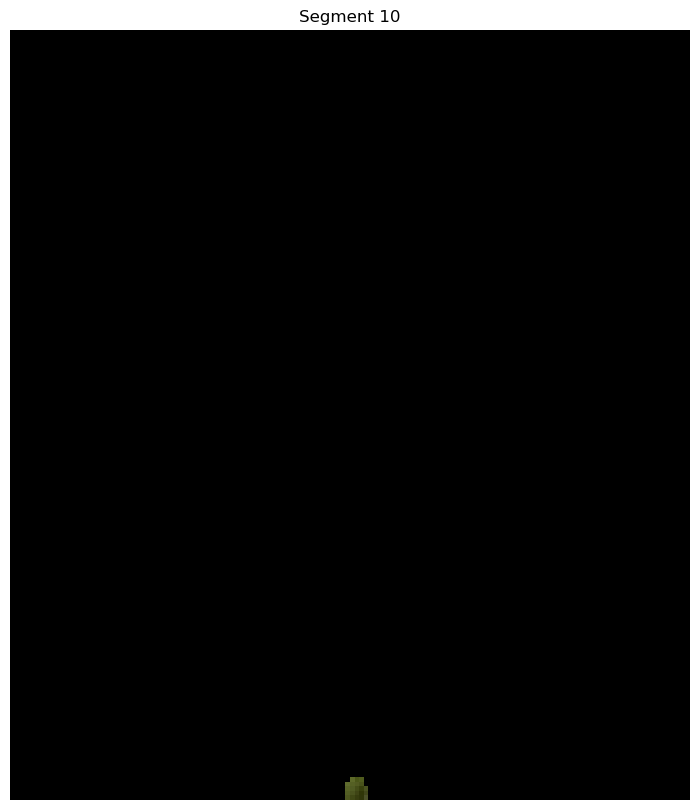

In [68]:
for idx, segmented_image in enumerate(segmented_images):
    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.title(f"Segment {idx + 1}")
    plt.show()

# Merge all the segments into one image

In [69]:
# Function to blend a segment onto a canvas
def blend_segment(canvas, segment, top, left):
    # Resize the original segment to its original size
    original_segment_resized = cv2.resize(segment, (segment_width, segment_height))

    # Create an alpha channel with reduced Gaussian blur
    alpha_channel = (original_segment_resized[..., 0] != 0).astype(np.uint8) * 255
    alpha_channel = cv2.GaussianBlur(alpha_channel, (0, 0), sigmaX=0.5)  # Adjust sigmaX as needed

    # Normalize alpha channel to be in the range [0, 1]
    alpha_blend = alpha_channel / 255.0

    # Blend the resized segment with the canvas using alpha blending
    for c in range(3):
        canvas[top:top + original_segment_resized.shape[0], left:left + original_segment_resized.shape[1], c] = (
            alpha_blend * original_segment_resized[..., c] + (1 - alpha_blend) * canvas[top:top + original_segment_resized.shape[0], left:left + original_segment_resized.shape[1], c]
        )

In [70]:
# Load the original image in RGB format
original_image = cv2.imread("G:\\NAVANEETH\\#Cotton_Leaf_Disease_Detection\\Dataset2\\Cotton-Disease-Training\\trainning\\Cotton leaves - Training\\800 Images\\Bacterial blight\\11.jpg") 
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  

# Check if the image is loaded successfully
if original_image is None:
    raise ValueError("Failed to load the original image. Please check the file path.")

# Get the dimensions of the original image
original_height, original_width, _ = original_image.shape

# Define canvas dimensions
canvas_height = original_height
canvas_width = original_width

# Create a canvas to merge segments onto
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

In [71]:
# Iterate through masks and apply them to the canvas
for idx, mask in enumerate(masks):
    segmentation_mask = mask['segmentation']
    binary_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    binary_mask[segmentation_mask] = 255

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through contours and blend each segment onto the canvas
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Set segment width and height dynamically
        segment_width, segment_height = w, h

        segment = original_image[y:y+h, x:x+w, :]

        # Calculate the top-left position for blending
        top = y
        left = x

        # Blend the segment onto the canvas
        blend_segment(canvas, segment, top, left)

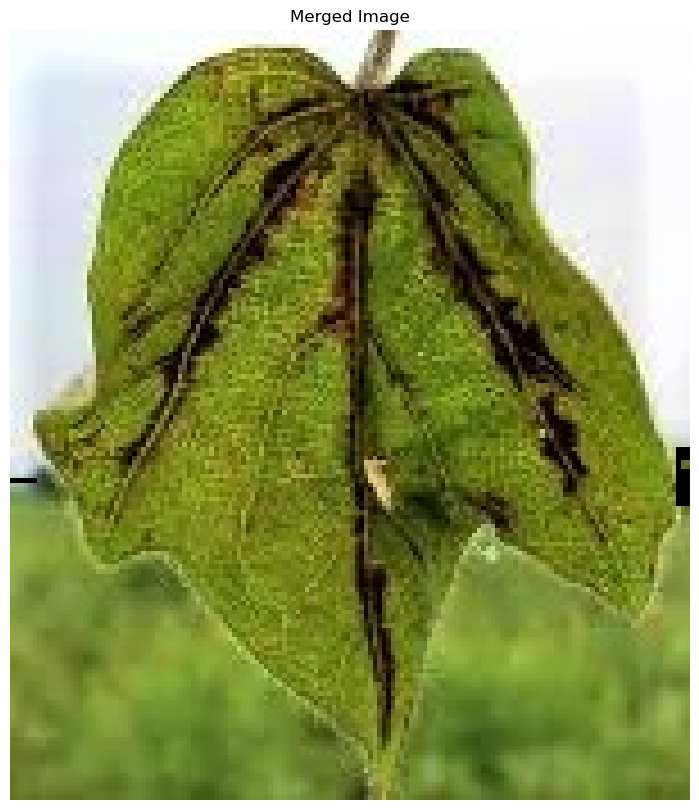

In [72]:
# Display the merged image
plt.figure(figsize=(10, 10))
plt.imshow(canvas)
plt.axis('off')
plt.title("Merged Image")
plt.show()


# Save the merged segmented image

In [74]:
original_image_path = "G:\\NAVANEETH\\#Cotton_Leaf_Disease_Detection\\Dataset2\\Cotton-Disease-Training\\trainning\\Cotton leaves - Training\\800 Images\\Bacterial blight\\11.jpg"

# Extract the filename and extension from the original image path
original_filename, original_extension = os.path.splitext(os.path.basename(original_image_path))

# Construct the output filename with "_sa" included
output_filename = f"{original_filename}_sa{original_extension}"

# Specify the output directory
output_directory = "G:\\NAVANEETH\\#Cotton_Leaf_Disease_Detection\\Segmented_Dataset"

# Construct the full output filepath
output_filepath = os.path.join(output_directory, output_filename)

# Save the merged image to the specified file
cv2.imwrite(output_filepath, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))

print(f"Generated image saved to: {output_filepath}")


Generated image saved to: G:\NAVANEETH\#Cotton_Leaf_Disease_Detection\Segmented_Dataset\11_sa.jpg
